# Modular coding - simple modularity

## Toy example with pure PyTorch

Let's consider the following simple toy model (multilayer perceptron) training code:

In [1]:
# Import needed modules
import torch

from torchvision import datasets
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor

from torch import nn

from tqdm import tqdm

import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Set up data sets and data loaders

data_dir = "./data"

batch_size = 32

train_dataset = datasets.MNIST(
    data_dir, train=True, download=True, transform=ToTensor()
)
test_dataset = datasets.MNIST(data_dir, train=False, transform=ToTensor())

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

In [3]:
# Specify model

device = "cuda" if torch.cuda.is_available() else "cpu"


class SimpleMLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Flatten(), nn.Linear(28 * 28, 20), nn.ReLU(), nn.Linear(20, 10)
        )

    def forward(self, x):
        return self.layers(x)


model = SimpleMLP().to(device)
print(model)

SimpleMLP(
  (layers): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=20, bias=True)
    (2): ReLU()
    (3): Linear(in_features=20, out_features=10, bias=True)
  )
)


In [4]:
# Specify loss and optimizer

criterion = torch.nn.CrossEntropyLoss()

optimizer = torch.optim.AdamW(model.parameters())

In [5]:
# Train the model

model.train()

num_batches = len(train_loader)
num_items = len(train_loader.dataset)
losses = []
accuracies = []
epochs = 5

for epoch in range(epochs):
    total_loss = 0
    total_correct = 0
    for data, target in tqdm(train_loader, total=num_batches):
        # Copy data and targets to GPU
        data = data.to(device)
        target = target.to(device)

        # Do a forward pass
        outputs = model(data)

        # Calculate the loss
        loss = criterion(outputs, target)
        total_loss += loss.item()

        # Count number of correct digits
        _, predicted = torch.max(outputs, 1)
        total_correct += (predicted == target).sum().item()

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    train_loss = total_loss / num_batches
    accuracy = total_correct / num_items
    print(f"Average loss: {train_loss:7f}, accuracy: {accuracy:.2%}")
    losses.append(train_loss)
    accuracies.append(accuracy)

100%|██████████| 1875/1875 [00:03<00:00, 508.00it/s]


Average loss: 0.448582, accuracy: 87.81%


100%|██████████| 1875/1875 [00:03<00:00, 502.12it/s]


Average loss: 0.252599, accuracy: 92.80%


100%|██████████| 1875/1875 [00:03<00:00, 532.66it/s]


Average loss: 0.216163, accuracy: 93.85%


100%|██████████| 1875/1875 [00:03<00:00, 538.40it/s]


Average loss: 0.192356, accuracy: 94.50%


100%|██████████| 1875/1875 [00:03<00:00, 531.97it/s]

Average loss: 0.173849, accuracy: 95.02%


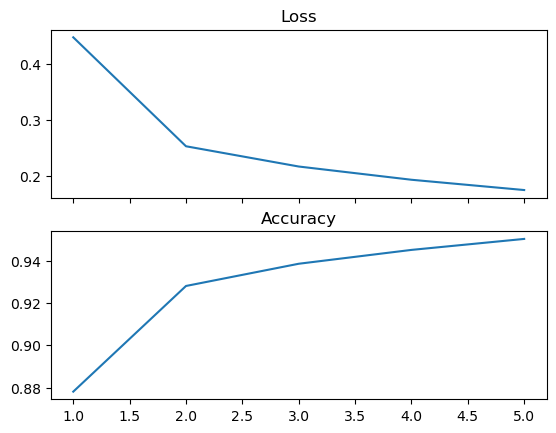

In [6]:
batch_index = np.arange(1, len(losses) + 1)

fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=True)

ax1.plot(batch_index, np.asarray(losses))
ax1.set_title("Loss")
ax2.plot(batch_index, np.asarray(accuracies))
ax2.set_title("Accuracy")

fig.show()

In [7]:
# Validate the model
model.eval()

num_test_batches = len(test_loader)
num_test_items = len(test_loader.dataset)

test_total_correct = 0
for data, target in tqdm(test_loader, total=num_test_batches):
    # Copy data and targets to GPU
    data = data.to(device)
    target = target.to(device)

    # Do a forward pass
    outputs = model(data)

    # Count number of correct digits
    _, predicted = torch.max(outputs, 1)
    test_total_correct += (predicted == target).sum().item()

test_accuracy = test_total_correct / num_test_items
print(f"Validation accuracy: {test_accuracy:.2%}")

100%|██████████| 313/313 [00:00<00:00, 662.18it/s]

Validation accuracy: 94.67%


## Quick modular improvements

Because the model and dataset are very simple, the code is relatively clean and it can be organized in a linear fashion. For more complicated setups this can be 

However it can be made clearer and more modular by writing the training and testing parts as functions.

In [8]:
# Reset the notebook
%reset -f

In [9]:
# Redo imports
import torch

from torchvision import datasets
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor

from torch import nn

from tqdm import tqdm

import matplotlib.pyplot as plt
import numpy as np

### Dataloaders

Creating the data loaders can be split into its own function:

In [10]:
def create_dataloaders(train_dataset, test_dataset, batch_size=32):
    # Set up data loaders based on datasets

    train_loader = DataLoader(
        dataset=train_dataset, batch_size=batch_size, shuffle=True
    )
    test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, test_loader

### Model

Model creation can be done in a separate function that accepts a model structure and optimizer class as its inputs:

In [11]:
def create_model(model_structure, optimizer_class, device="cpu"):
    # Define function for getting model and optimizer
    model = model_structure().to(device)
    optimizer = optimizer_class(model.parameters())
    return model, optimizer

In [12]:
# Define training and validation functions
def train(
    model, dataloader, criterion, optimizer, batch_size=32, epochs=5, device="cpu"
):

    model.train()

    num_batches = len(dataloader)
    num_items = len(dataloader.dataset)
    losses = []
    accuracies = []

    for epoch in range(epochs):
        total_loss = 0
        total_correct = 0
        for data, target in tqdm(dataloader, total=num_batches):
            # Copy data and targets to GPU
            data = data.to(device)
            target = target.to(device)

            # Do a forward pass
            outputs = model(data)

            # Calculate the loss
            loss = criterion(outputs, target)
            total_loss += loss.item()

            # Count number of correct digits
            _, predicted = torch.max(outputs, 1)
            total_correct += (predicted == target).sum().item()

            # Backpropagation
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        train_loss = total_loss / num_batches
        accuracy = total_correct / num_items
        print(f"Average loss: {train_loss:7f}, accuracy: {accuracy:.2%}")
        losses.append(train_loss)
        accuracies.append(accuracy)

    return losses, accuracies


def validate(model, dataloader, criterion, device="cpu"):
    # Validate the model
    model.eval()

    num_batches = len(dataloader)
    num_items = len(dataloader.dataset)

    total_correct = 0
    for data, target in tqdm(test_loader, total=num_batches):
        # Copy data and targets to GPU
        data = data.to(device)
        target = target.to(device)

        # Do a forward pass
        outputs = model(data)

        # Count number of correct digits
        _, predicted = torch.max(outputs, 1)
        total_correct += (predicted == target).sum().item()

    accuracy = total_correct / num_items
    print(f"Validation accuracy: {accuracy:.2%}")
    return accuracy

### Plotting results

Lets create a function for plotting results:

In [13]:
def plot_training(losses, accuracies):

    batch_index = np.arange(1, len(losses) + 1)

    fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=True)

    ax1.plot(batch_index, np.asarray(losses))
    ax1.set_title("Loss")
    ax2.plot(batch_index, np.asarray(accuracies))
    ax2.set_title("Accuracy")

    return fig, (ax1, ax2)

### Using the modular version of the code

In [14]:
# Set all variables

data_dir = "./data"
train_dataset = datasets.MNIST(
    data_dir, train=True, download=True, transform=ToTensor()
)
test_dataset = datasets.MNIST(data_dir, train=False, transform=ToTensor())
batch_size = 32


class SimpleMLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Flatten(), nn.Linear(28 * 28, 20), nn.ReLU(), nn.Linear(20, 10)
        )

    def forward(self, x):
        return self.layers(x)


model_structure = SimpleMLP
optimizer_class = torch.optim.AdamW
criterion = torch.nn.CrossEntropyLoss()
epochs = 5

device = "cuda" if torch.cuda.is_available() else "cpu"

In [15]:
train_loader, test_loader = create_dataloaders(
    train_dataset, test_dataset, batch_size=32
)
model, optimizer = create_model(model_structure, optimizer_class, device=device)

In [20]:
%%time
# Train the model
losses, accuracies = train(
    model,
    train_loader,
    criterion,
    optimizer,
    batch_size=batch_size,
    epochs=epochs,
    device=device,
)

100%|██████████| 1875/1875 [00:03<00:00, 517.73it/s]


Average loss: 0.117855, accuracy: 96.49%


100%|██████████| 1875/1875 [00:03<00:00, 519.64it/s]


Average loss: 0.113927, accuracy: 96.62%


100%|██████████| 1875/1875 [00:03<00:00, 505.54it/s]


Average loss: 0.110120, accuracy: 96.73%


100%|██████████| 1875/1875 [00:03<00:00, 531.13it/s]


Average loss: 0.106496, accuracy: 96.83%


100%|██████████| 1875/1875 [00:03<00:00, 515.40it/s]

Average loss: 0.104466, accuracy: 96.88%
CPU times: user 18.5 s, sys: 2.54 s, total: 21 s
Wall time: 18.1 s


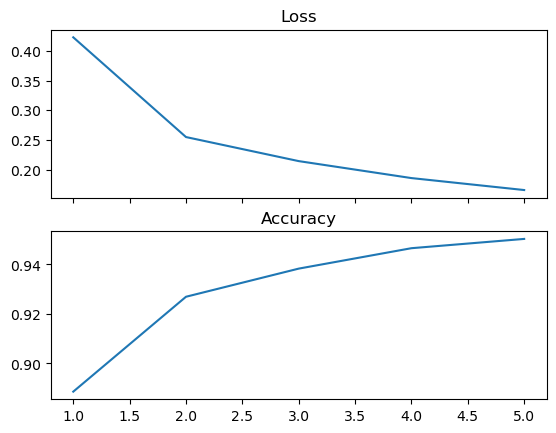

In [17]:
# Plot training
fig, axes = plot_training(losses, accuracies)

fig.show()

In [18]:
# Validate model

validate(model, test_loader, criterion, device=device)

100%|██████████| 313/313 [00:00<00:00, 711.76it/s]

Validation accuracy: 94.66%


0.9466